
# Nonlinear Elastica with Parametrized Imperfection

This notebook solves the problem of an inextensible, unshearable beam modelled as a nonlinear elastica. 

We use an energetic approach to solve the quasi-static problem as a constrained optimization problem. The beam is subject to a vertical tip force and a horizontal compressive load, with an initial imperfection.

We use:
- **CasADi** for symbolic modeling and automatic differentiation
- **IPOPT** to solve the resulting nonlinear optimization problem
- **Matplotlib** to visualize:
  - Deformed shapes
  - Tip displacement vs load
  - Tip rotation vs load

We model imperfection as a constant inelastic curvature `k₀`, treated as a parameter.



## Mathematical Model and Numerical Method

We model a 2D slender, inextensible, and unshearable beam (Euler elastica) of length $ L $. Its configuration is described by:

- $ \underline{x}(s) = x(s)\underline{e}_1+ y(s)\underline{e}_2 $: centerline position along arc-length $ s \in [0, L] $
- $ \theta(s) $: angle between the tangent to the beam and the $\underline{e}_1$-axis

### Kinematic Constraints

Inextensibility and absence of shear deformation is enforced by:

$$
\underline{x}'(s) =  \cos\theta(s)\underline{e}_1+ \sin\theta(s)\underline{e}_2
$$

We consider here the case of a beam clamped at $s=0$ and free at $s=L$, leading to the following kinematical boundary conditions:
- $\theta(0) = 0$ (clamped)
- $x(0) = 0$ (clamped)
- $y(0) = 0$ (clamped)
### Energy Functional

We minimize the total energy composed of:

- **Bending energy** (with inelastic curvature $ k_0 $):

$$
\mathcal{E}_{elastic}(\theta) = \frac{EI}{2} \int_0^L \left( \frac{d\theta}{ds} - k_0 \right)^2 ds
$$

- **Work of external forces** (dead loads) $ \underline{F}=F_x\underline{e}_1+ F_y\underline{e}_2$:

$$
\mathcal{W}_{ext}(\underline{x}) = \underline{F} \cdot \underline{x}(L) = F_x x(L) + F_y y(L)
$$

The total energy is:
$$
\mathcal{E}_{total}(\underline{x},\theta) = \mathcal{E}_{elastic}(\theta) + \mathcal{W}_{ext}(\underline{x})
$$


The space of admissible configurations is defined by the inextensibility constraint and the boundary conditions:
$$
\mathcal{C} \equiv \left\{(\underline{x}, \theta) : \underline{x}'(s) =  \cos\theta(s)\underline{e}_1+ \sin\theta(s)\underline{e}_2, \;  x(0) = 0, \;y(0) = 0,\;\theta(0) = 0\right\}
$$
### Numerical Method

We discretize the beam using:

- Finite difference scheme over $ N $ nodes
- CasADi symbolic expressions to define constraints and energy
- IPOPT solver to find equilibrium configurations by minimizing the energy under constraints

The optimization variables are $ \theta_i, x_i, y_i $ at each node. We also treat $ F_x, F_y, k_0 $ as symbolic parameters to solve multiple loading scenarios.


---

### Numerical Method

We use **CasADi** to symbolically define the constraints and energy functional:

- CasADi builds a computational graph of the objective and constraints
- It automatically computes exact derivatives (Jacobian and Hessian) via **automatic differentiation**

We solve the resulting **nonlinear programming problem (NLP)** with [**IPOPT**](https://coin-or.github.io/Ipopt/), which is:

- An interior-point optimizer for large-scale nonlinear optimization
- Uses Newton's method with line search and barrier terms
- Solves linearized KKT systems at each step using sparse solvers (like MUMPS)

The beam problem leads to a **sparse, structured NLP**, with:

- $ 3N $ unknowns: $ \theta_i, x_i, y_i $
- $ 2(N-1) + 3 $ constraints (inextensibility + clamped)

---

### References

- Audoly, B., & Pomeau, Y. (2010). *Elasticity and Geometry*, Oxford University Press.
- Maurini, C. (lecture notes). *Nonlinear beams, Sorbonne Université*.
- Marigo, J.-J., MEC 430, Class notes at Ecole Polytechnique.
- CasADi documentation: https://web.casadi.org
- IPOPT documentation: https://coin-or.github.io/Ipopt/


---
<details>
<summary><strong> Constraints and Lagrange Multipliers</strong></summary>


The inextensibility constraint in the beam is enforced **pointwise** at each segment:

$$
\frac{dx}{ds} = \cos\theta(s), \quad \frac{dy}{ds} = \sin\theta(s)
$$

In the optimization framework, these constraints are added to the energy minimization problem using **Lagrange multipliers** internally by the solver.

IPOPT solves the Karush-Kuhn-Tucker (KKT) conditions for the constrained minimization problem:

- The **gradient of the Lagrangian** (objective + constraints) must vanish
- CasADi automatically provides exact Jacobians of the constraints
- The multipliers have a mechanical interpretation as generalized forces (e.g., axial forces or shear reactions)

The result is a system of nonlinear equations that IPOPT solves via Newton's method using sparse linear algebra.

See https://en.wikipedia.org/wiki/Lagrange_multiplier
</details>



<details>
<summary><strong> What is Automatic Differentiation (AD)?</strong></summary>

**Automatic Differentiation (AD)** is a computational technique for evaluating derivatives of functions defined by computer programs — **accurately and efficiently**.

Unlike:
- **Symbolic differentiation** (which manipulates expressions),
- **Numerical differentiation** (e.g., finite differences, which can be inaccurate),

AD works by **applying the chain rule at the level of elementary operations** (additions, multiplications, sin, cos, etc.), directly on the code.

There are two main modes:
- **Forward mode**: efficient for functions with few inputs
- **Reverse mode**: efficient for functions with many inputs and one output (common in optimization)

---

### AD in CasADi

CasADi uses **operator overloading** to build a symbolic graph of the computations and then applies AD (both forward and reverse) to compute:

- Gradients
- Jacobians
- Hessians

This is critical for **nonlinear constrained optimization**, where solvers like IPOPT require exact derivatives.

---

### References

- Andersson, J. A. E., Gillis, J., Horn, G., Rawlings, J. B., & Diehl, M. (2019).  
  *CasADi – A software framework for nonlinear optimization and optimal control*,  
  **Mathematical Programming Computation**, 11(1), 1–36.  
  [https://doi.org/10.1007/s12532-018-0139-4](https://doi.org/10.1007/s12532-018-0139-4)

- Griewank, A., & Walther, A. (2008).  
  *Evaluating Derivatives: Principles and Techniques of Algorithmic Differentiation*. SIAM.

- Naumann, U. (2012).  
  *The Art of Differentiating Computer Programs: An Introduction to Algorithmic Differentiation*. SIAM.

</details>


In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [ ]:
# Parameters
L = 1.0
EI = 1.0
N = 50
h = L / (N - 1)

# Symbolic variables
theta = ca.MX.sym("theta", N)
x = ca.MX.sym("x", N)
y = ca.MX.sym("y", N)
Fx = ca.MX.sym("Fx")   # Horizontal force (compression)
Fy = ca.MX.sym("Fy")   # Vertical tip force
k0 = ca.MX.sym("k0")   # Initial curvature
Z = ca.vertcat(theta, x, y)
F0 = EI / L ** 2  # Scaling factor for the force

# Constraints
constraints = []
# Inextensibility and unsheareability
for i in range(N - 1):
    constraints.append((x[i+1] - x[i]) / h - ca.cos(theta[i]))
    constraints.append((y[i+1] - y[i]) / h - ca.sin(theta[i]))
# Dirichlet boundary conditions
constraints.append(theta[0])
constraints.append(x[0])
constraints.append(y[0])
# Reshaping
g = ca.vertcat(*constraints)

# Energy
bending = sum(0.5 * EI * (((theta[i+1] - theta[i]) / h - k0)**2) * h for i in range(N - 1))
potential = -Fy * (y[-1] - y[0]) - Fx * (x[-1] - x[0])
total_energy = bending + potential

# Problem
params = ca.vertcat(Fx, Fy, k0)
nlp = {"x": Z, "p": params, "f": total_energy, "g": g}
opts = {"ipopt": {"print_level": 0, "tol": 1e-8, "linear_solver": "mumps","sb": "yes"},"print_time": False}
solver = ca.nlpsol("solver", "ipopt", nlp, opts)

In [3]:
theta0 = 0.01 * np.sin(np.linspace(0, np.pi, N))  # Perturbation to trigger buckling
x0 = np.linspace(0, L, N)
y0 = np.zeros(N)
z0 = np.concatenate([theta0, x0, y0])


### Comparison with Linear Beam Theory

In the first example, we apply a vertical load at the free tip of a clamped beam. The linear Euler-Bernoulli beam theory predicts the tip deflection as:

$$
y_{\text{tip}}^{\text{linear}} = -\frac{F_y L^3}{3EI}
$$

This formula is valid for small displacements and rotations. In our simulation, we compare it with the **nonlinear solution** from the Elastica model.

This lets us observe the deviation from linearity as the load increases and the beam undergoes large deflections.


## Example 1: Vertical Tip Load (No Imperfection)

In [4]:
load_values = np.linspace(0, 4, 50) * F0
k0_val = 0.0

shapes = []
tip_deflections = []
tip_rotations = []

for Fy_val in load_values:
    sol = solver(x0=z0, p=[0.0, Fy_val, k0_val], lbg=0, ubg=0)
    stats = solver.stats()
    print(f"Load={Fy_val:.3f} | Status={stats['return_status']} | N:Iterations={stats['iter_count']}")
    z_opt = sol['x'].full().flatten()
    z0 = z_opt
    theta_sol = z_opt[:N]
    x_sol = z_opt[N:2*N]
    y_sol = z_opt[2*N:]
    shapes.append((x_sol.copy(), y_sol.copy()))
    tip_deflections.append(-y_sol[-1])
    tip_rotations.append(theta_sol[-1])
    linear_tip = -Fy_val * L**3 / (3 * EI)

Load=0.000 | Status=Solve_Succeeded | N:Iterations=2
Load=0.082 | Status=Solve_Succeeded | N:Iterations=2
Load=0.163 | Status=Solve_Succeeded | N:Iterations=2
Load=0.245 | Status=Solve_Succeeded | N:Iterations=2
Load=0.327 | Status=Solve_Succeeded | N:Iterations=2
Load=0.408 | Status=Solve_Succeeded | N:Iterations=2
Load=0.490 | Status=Solve_Succeeded | N:Iterations=2
Load=0.571 | Status=Solve_Succeeded | N:Iterations=2
Load=0.653 | Status=Solve_Succeeded | N:Iterations=3
Load=0.735 | Status=Solve_Succeeded | N:Iterations=3
Load=0.816 | Status=Solve_Succeeded | N:Iterations=3
Load=0.898 | Status=Solve_Succeeded | N:Iterations=3
Load=0.980 | Status=Solve_Succeeded | N:Iterations=3
Load=1.061 | Status=Solve_Succeeded | N:Iterations=3
Load=1.143 | Status=Solve_Succeeded | N:Iterations=3
Load=1.224 | Status=Solve_Succeeded | N:Iterations=3
Load=1.306 | Status=Solve_Succeeded | N:Iterations=2
Load=1.388 | Status=Solve_Succeeded | N:Iterations=2
Load=1.469 | Status=Solve_Succeeded | N:Iterat

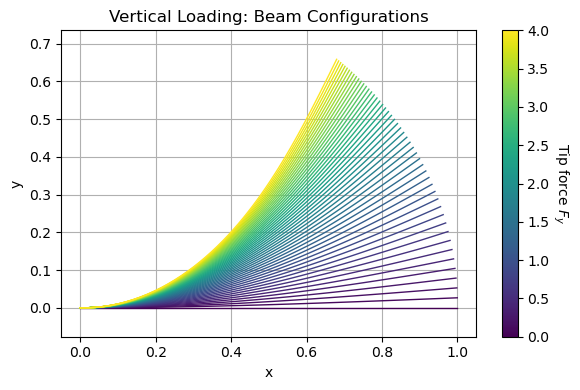

In [5]:
# Plot shapes
cmap = cm.viridis
norm = mcolors.Normalize(vmin=load_values[0], vmax=load_values[-1])
fig, ax = plt.subplots(figsize=(6, 4))
for i, (xv, yv) in enumerate(shapes):
    ax.plot(xv, yv, color=cmap(norm(load_values[i])), linewidth=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Tip force $F_y$", rotation=270, labelpad=15)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Vertical Loading: Beam Configurations")
ax.axis("equal")
ax.grid(True)
plt.tight_layout()
plt.show()

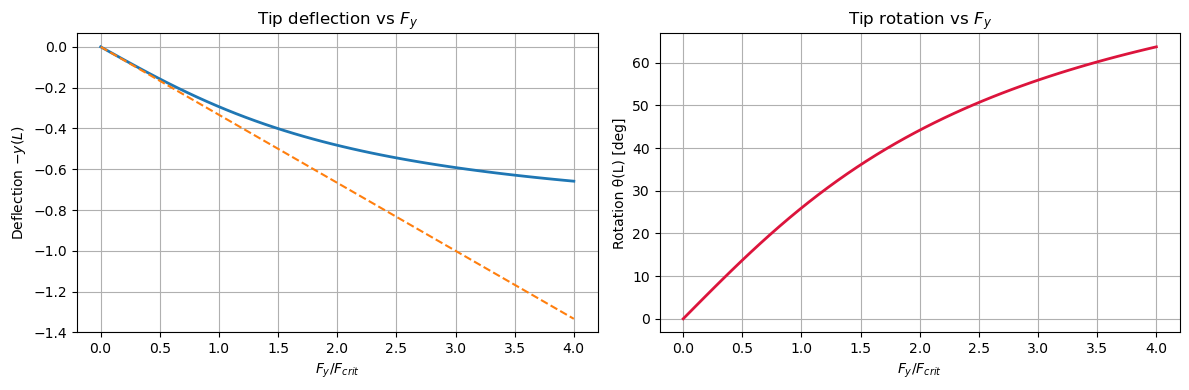

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(load_values / F0, tip_deflections, lw=2)
ax[0].set_title("Tip deflection vs $F_y$")
ax[0].set_xlabel("$F_y / F_{crit}$")
ax[0].set_ylabel("Deflection $-y(L)$")
ax[0].plot(load_values / F0, [ -Fy * L**3 / (3 * EI) for Fy in load_values], '--', label='Linear theory')
ax[0].grid(True)

ax[1].plot(load_values / F0, np.rad2deg(tip_rotations), lw=2, color='crimson')
ax[1].set_title("Tip rotation vs $F_y$")
ax[1].set_xlabel("$F_y / F_{crit}$")
ax[1].set_ylabel("Rotation θ(L) [deg]")
ax[1].grid(True)
plt.tight_layout()
plt.show()


### Analytical Buckling Load

Euler's formula for the critical buckling load depends on the beam’s **boundary conditions**:

| Boundary Condition | Effective Length $ K $ | Critical Load $ F_{\text{crit}} $ |
|--------------------|----------------------------|----------------------------------------|
| Pinned-Pinned      | 1                          | $ \frac{\pi^2 EI}{L^2} $         |
| Clamped-Free       | 2                          | $ \frac{\pi^2 EI}{4L^2} $       |

In this notebook, we consider a **clamped-free (cantilever)** beam, so:

$$
F_{\text{crit}} = \frac{\pi^2 EI}{4 L^2}
$$

We include a dashed vertical line in the buckling plots to indicate this **theoretical bifurcation point**.


## Example 2: Axial Compression with Imperfection

In [7]:
F_crit = np.pi ** 2 / 4
compression_values = np.linspace(0, 3, 60) * F_crit
k0_val = 0.002 * np.pi / L  # larger imperfection

z0 = np.concatenate([theta0, x0, y0])
shapes = []
tip_displacements = []
tip_rotations = []


for Fx_val in compression_values:
    sol = solver(x0=z0, p=[-Fx_val, 0.0, k0_val], lbg=0, ubg=0, 
                 lbx=-np.inf, ubx=np.inf)
    print(f"Load={Fy_val:.3f} | Status={stats['return_status']} | N:Iterations={stats['iter_count']}")
    z_opt = sol['x'].full().flatten()
    z0 = z_opt
    theta_sol = z_opt[:N]
    x_sol = z_opt[N:2*N]
    y_sol = z_opt[2*N:]
    shapes.append((x_sol.copy(), y_sol.copy()))
    tip_displacements.append(x_sol[-1] - x_sol[0])
    tip_rotations.append(theta_sol[-1])

Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterations=2
Load=4.000 | Status=Solve_Succeeded | N:Iterat

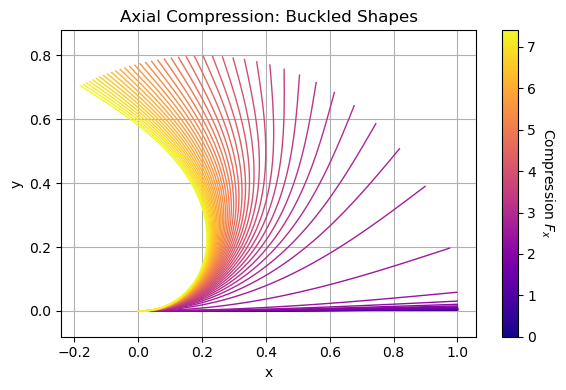

In [8]:
cmap = cm.plasma
norm = mcolors.Normalize(vmin=compression_values[0], vmax=compression_values[-1])
fig, ax = plt.subplots(figsize=(6, 4))
for i, (xb, yb) in enumerate(shapes):
    ax.plot(xb, yb, color=cmap(norm(compression_values[i])), linewidth=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Compression $F_x$", rotation=270, labelpad=15)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Axial Compression: Buckled Shapes")
ax.axis("equal")
ax.grid(True)
plt.tight_layout()
plt.show()

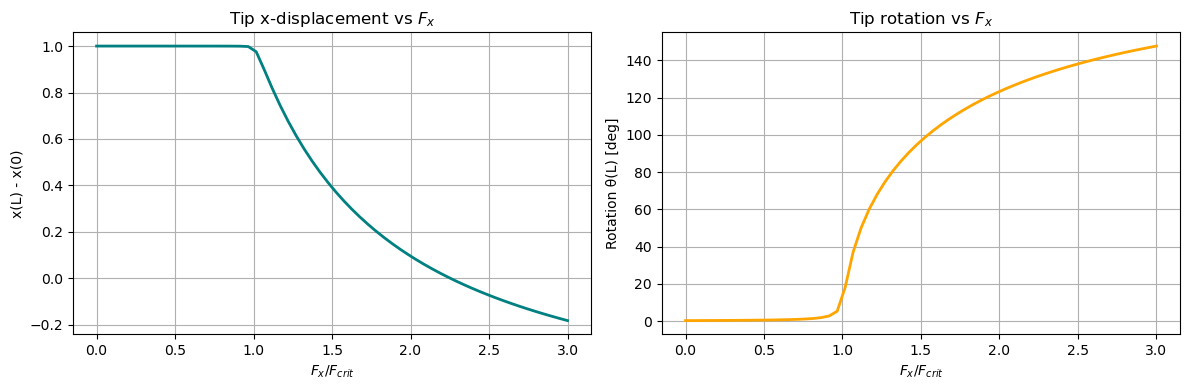

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(compression_values / F_crit, tip_displacements, lw=2, color='teal')
ax[0].set_title("Tip x-displacement vs $F_x$")
ax[0].set_xlabel("$F_x / F_{crit}$")
ax[0].set_ylabel("x(L) - x(0)")
ax[0].grid(True)

ax[1].plot(compression_values / F_crit, np.rad2deg(tip_rotations), lw=2, color='orange')
ax[1].set_title("Tip rotation vs $F_x$")
ax[1].set_xlabel("$F_x / F_{crit}$")
ax[1].set_ylabel("Rotation θ(L) [deg]")
ax[1].grid(True)
plt.tight_layout()
plt.show()
ax[0].axvline(1.0, color='gray', ls='--', label='Analytical $F_{crit}$')
ax[0].legend()